In [5]:
import matplotlib.pyplot as ptl
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer



In [8]:
hotel = pd.read_csv("./archive/hotel.csv")
hotel.head()

X= hotel.copy()
y = hotel.pop("is_canceled")

X["arrival_date_month"] = X["arrival_date_month"].map({
    "January":1, "February":2, "March":3, "April":4, "May":5, "June":6,
    "July":7, "August":8, "September":9, "October":10, "November":11, "December":12
})


features_num = [
    "lead_time", "arrival_date_week_number",
    "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies",
    "is_repeated_guest", "previous_cancellations",
    "previous_bookings_not_canceled", "required_car_parking_spaces",
    "total_of_special_requests", "adr",
]
features_cat = [
    "hotel", "arrival_date_month", "meal",
    "market_segment", "distribution_channel",
    "reserved_room_type", "deposit_type", "customer_type",
]

transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

X_train, X_valid, y_train, y_valid =  train_test_split(X, y, stratify=y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]


In [9]:
from tensorflow import keras
from tensorflow.keras import layers

<Axes: title={'center': 'Accuracy'}>

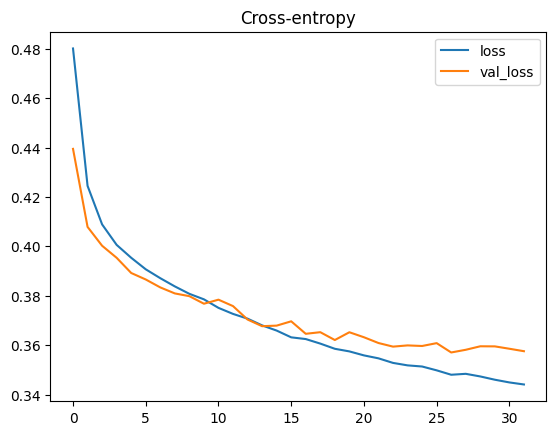

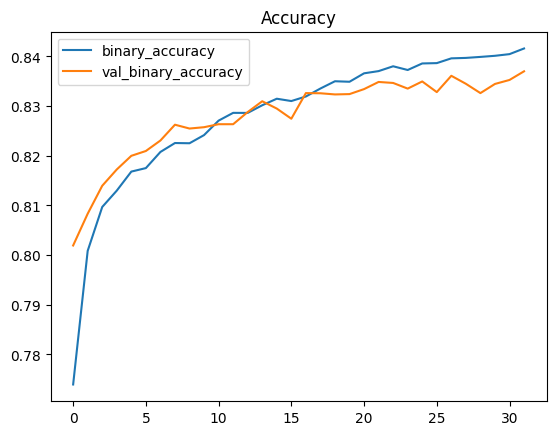

In [15]:
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(256,activation = "relu"),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),
    layers.Dense(256,activation = "relu"),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),
    layers.Dense(1,activation="sigmoid")
])

model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=["binary_accuracy"]
)

early_stoping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_train,y_train,
    validation_data=(X_valid,y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stoping],
    verbose=0
)

history_df = pd.DataFrame(history.history)

history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")
